In [2]:
from tf_unet_modified import unet
from tf_unet_modified.Trainer import Trainer
from tf_unet_modified.Trainer import error_rate
import tensorflow as tf
from BatchGeneration import Batch
from DataPreparation import DataPreparation
from utils import *
import os
import tables
import numpy as np
from copy import deepcopy
import cv2
import time
import matplotlib.pyplot as plt


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [25]:
trainhdf5filename = "data/Tracking_Robotic_Training/Training_set/train_images_224_10_joints.hdf5"
testhdf5filename = "data/Test_set/test_images_224_10_joints.hdf5"

In [26]:
class BatchGenerator:
    def __init__(self, train_images, train_classi_labels, train_locali_labels, test_images, test_classi_labels,
                 test_locali_labels):
        self._timages = train_images
        self._tclabels = train_classi_labels
        self._tllabels = train_locali_labels
        self._testimages = test_images
        self._testclabels = test_classi_labels
        self._testllabels = test_locali_labels

        self.train_offset = 0
        self.val_offset = 0
        self.test_offset= 0
        
        self.tr_size = self._timages.shape[0]
        self.test_size = self._testimages.shape[0]
        self.val_size = int(np.floor(self.test_size * 0.3)) # Use 30% of test set as validation
        
        self.indices_train = np.arange(self.tr_size)
        self.indices_test = np.arange(self.test_size)

        np.random.shuffle(self.indices_train)
        np.random.shuffle(self.indices_test)
        
        self.indices_val = self.indices_test[0:self.val_size]
        self.indices_test = self.indices_test[self.val_size:]
        self.test_size = len(self.indices_test)

    def get_next_training_batch(self, batch_size):
        images = []
        clabels = []
        llabels = []
        if len(self.indices_train) >= batch_size:
            images = self._timages[self.indices_train[0:batch_size],:]
            clabels = self._tclabels[self.indices_train[0:batch_size],:]
            llabels = self._tllabels[self.indices_train[0:batch_size],:]
            self.indices_train = self.indices_train[batch_size:]
        else:
            images = self._timages[self.indices_train[0:],:]
            clabels = self._tclabels[self.indices_train[0:],:]
            llabels = self._tllabels[self.indices_train[0:],:]
            self.indices_train = []
            
        if len(self.indices_train) == 0:
            print("Training epoch happening after this return")
            # An epoch happened on val data
            # shuffle VALIDATION data indices
            self.indices_train = np.arange(self.tr_size)
            np.random.shuffle(self.indices_train)
        return images, clabels, llabels
    
    def get_next_validation_batch(self, batch_size):
        images = []
        clabels = []
        tlabels = []
        if (self.val_offset + batch_size) <= len(self.indices_val):
            images = self._testimages[self.indices_val[0:batch_size], :]
            clabels = self._testclabels[self.indices_val[0:batch_size], :]
            llabels = self._testllabels[self.indices_val[0:batch_size], :]
            self.val_offset += batch_size
        else:
            images = self._testimages[self.indices_val[0:],:]
            clabels = self._testclabels[self.indices_val[0:],:]
            llabels = self._testllabels[self.indices_val[0:],:]
            self.val_offset += batch_size
            
        if self.val_offset >= len(self.indices_val):
            print("Validation epoch happening after this return")
            # An epoch happened on val data
            # shuffle VALIDATION data indices
            np.random.shuffle(self.indices_val)
            self.val_offset = 0
        return images, clabels, llabels
    
    def get_next_test_batch(self, batch_size):
        images = []
        clabels = []
        tlabels = []
        if (self.test_offset + batch_size) <= len(self.indices_test):
            images = self._testimages[self.indices_test[0:batch_size], :]
            clabels = self._testclabels[self.indices_test[0:batch_size], :]
            llabels = self._testllabels[self.indices_test[0:batch_size], :]
            self.test_offset += batch_size
        else:
            images = self._testimages[self.indices_test[0:],:]
            clabels = self._testclabels[self.indices_test[0:],:]
            llabels = self._Testllabels[self.indices_test[0:],:]
            self.test_offset += batch_size
            
        if self.test_offset >= len(self.indices_test):
            print("Test epoch happening after this return")
            # An epoch happened on test data
            # shuffle TEST data indices
            np.random.shuffle(self.indices_test)
            self.test_offset = 0
        return images, clabels, llabels
    


In [27]:
class DataProvider:
    """
    Class which provides data related functions
    """

    def __init__(self, trainhdf5file, testhdf5file):
        trainhdf5file = os.path.abspath(trainhdf5file)
        testhdf5file = os.path.abspath(testhdf5file)

        trainhdf5file = tables.open_file(trainhdf5file, "r")
        testhdf5file = tables.open_file(testhdf5file, "r")
        print(trainhdf5file)
        print(testhdf5file)
        
        self.train_X = trainhdf5file.root.images
        self.train_classi_Y = trainhdf5file.root.classilabels
        self.train_locali_Y = trainhdf5file.root.localilabels
        
        self.test_X = testhdf5file.root.images
        self.test_classi_Y = testhdf5file.root.classilabels
        self.test_locali_Y = testhdf5file.root.localilabels
    
        # To make everything fast at the expense of huge RAM usage, pass these handlers as numpy arrays 
        # to BatchGenerator
        self.batch_handler = BatchGenerator(self.train_X, self.train_classi_Y, self.train_locali_Y,
                                            self.test_X, self.test_classi_Y, self.test_locali_Y)

    def get_training_batch(self, n):
        return self.batch_handler.get_next_training_batch(n)
    
    def no_validation_batches(self, batch_size):
        if len(self.batch_handler.indices_validation)%batch_size == 0:
            return len(self.batch_handler.indices_validation)/batch_size
        else:
            return len(self.batch_handler.indices_validation)/batch_size + 1
        
    def get_validation_batch(self, n):
        return self.batch_handler.get_next_validation_batch(n)

In [29]:
# Test data preparator
data_provider = DataProvider(trainhdf5filename, trainhdf5filename)
tr_X, tr_classi, tr_locali = data_provider.get_training_batch(50)
te_X, te_classi, te_locali = data_provider.get_validation_batch(50)


IOError: ``/home/mlmi/Desktop/MLMI_PROJECT_IBRAR/MLMI-REPO_v1_classi+locali_batchsize-=10/data/Tracking_Robotic_Training/Training_set/train_images_224_10_joints.hdf5`` does not exist

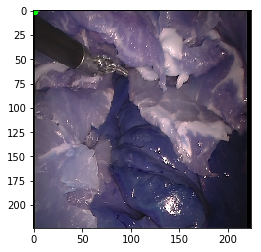

In [13]:
plt.imshow(tr_X[20])
plt.show()

In [22]:
print(tr_X.shape)
print(tr_classi.shape)
print(tr_locali.shape)

(50, 224, 224, 3)
(50, 4)
(50, 10, 224, 224)


Print train images now
84
125
[1 1 0 0]


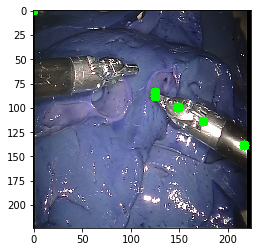

> <ipython-input-24-a990dac3ddba>(6)<module>()
-> for joint in range(new_pmaps.shape[0]):
(Pdb) 
(Pdb) c
88
125
[1 1 0 0]


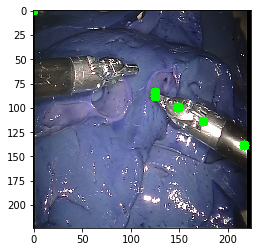

> <ipython-input-24-a990dac3ddba>(6)<module>()
-> for joint in range(new_pmaps.shape[0]):
(Pdb) c
114
175
[1 1 0 0]


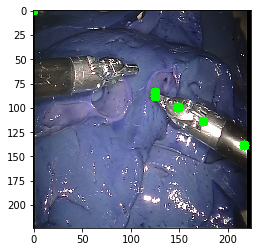

> <ipython-input-24-a990dac3ddba>(6)<module>()
-> for joint in range(new_pmaps.shape[0]):
(Pdb) c
139
217
[1 1 0 0]


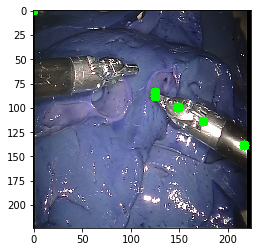

> <ipython-input-24-a990dac3ddba>(6)<module>()
-> for joint in range(new_pmaps.shape[0]):
(Pdb) c
100
149
[1 1 0 0]


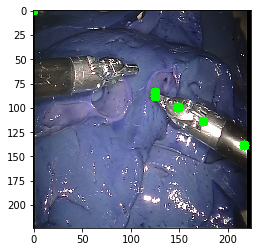

> <ipython-input-24-a990dac3ddba>(6)<module>()
-> for joint in range(new_pmaps.shape[0]):
(Pdb) 
(Pdb) c
0
0
[1 1 0 0]


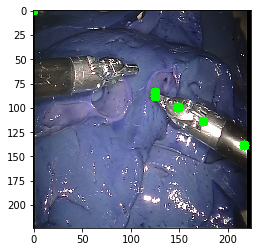

> <ipython-input-24-a990dac3ddba>(6)<module>()
-> for joint in range(new_pmaps.shape[0]):
(Pdb) c
0
0
[1 1 0 0]


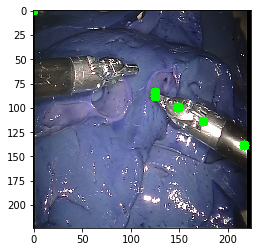

> <ipython-input-24-a990dac3ddba>(6)<module>()
-> for joint in range(new_pmaps.shape[0]):
(Pdb) c
0
0
[1 1 0 0]


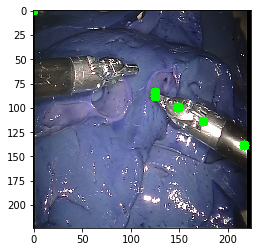

> <ipython-input-24-a990dac3ddba>(6)<module>()
-> for joint in range(new_pmaps.shape[0]):
(Pdb) c
0
0
[1 1 0 0]


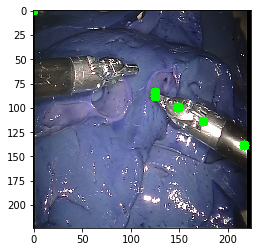

> <ipython-input-24-a990dac3ddba>(6)<module>()
-> for joint in range(new_pmaps.shape[0]):
(Pdb) c
0
0
[1 1 0 0]


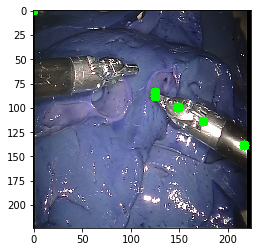

> <ipython-input-24-a990dac3ddba>(6)<module>()
-> for joint in range(new_pmaps.shape[0]):
(Pdb) c


In [24]:
print ("Print train images now")
#for i in range(tr_X.shape[0]):
for i in range(1):
    gray = tr_X[i]
    new_pmaps = tr_locali[i]
    for joint in range(new_pmaps.shape[0]):
        #print(np.sum(new_pmaps[joint,:,:]))
        x,y = np.unravel_index(new_pmaps[joint,:,:].argmax(),[224,224])
        print(x)
        print(y)
        cv2.circle(gray,(int(y),int(x)), 5, (0,255,0), -1)
        print(tr_classi[i])
        plt.imshow(gray)
        plt.show()
        import pdb; pdb.set_trace()
        
